In [1]:
from ROOT import TFile, TTree, TMVA, TCut, TH1F, TH2F, TCanvas, TPad

import numpy as np
from array import array

import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.utils.data as Data

Welcome to JupyROOT 6.28/02


In [2]:
TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize()

In [3]:
class NetworkModel(nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        super(NetworkModel, self).__init__()
        self.hid1 = nn.Linear(n_features, n_hidden)
        self.hid2 = nn.Linear(n_hidden, n_hidden)
        self.hid3 = nn.Linear(n_hidden, n_hidden)
        self.output = nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        x = torch.sigmoid(self.hid1(x))
        x = torch.sigmoid(self.hid2(x))
        x = torch.sigmoid(self.hid3(x))
        x = self.output(x)
        return x

modelQ2 = NetworkModel(4, 128, 1)

In [4]:
def train(model, trainloader, valloader, num_epochs,
          batch_size, optimizer, criterion, save_best, scheduler):
    trainer = optimizer(model.parameters(), lr=0.01)
    schedule, scheduleSteps = scheduler
    best_val = None
    
    for epoch in range(num_epochs):
        running_loss_train = 0.0
        running_loss_val = 0.0
        
        model.train()
        for i, (X, y) in enumerate(trainloader):
            X = Variable(X)
            y = Variable(y)
            
            trainer.zero_grad()
            output = model(X)
            train_loss = criterion(output, y)
            train_loss.backward()
            trainer.step()
            
            running_loss_train += train_loss.item()
            if i % 32 == 31:
                print('[Epoch {}, Item {}] Training Loss: {:.3f}'
                      .format(epoch+1, i+1, running_loss_train / 32))
                running_loss_train = 0.0
            
        if schedule:
            schedule(optimizer, epoch, schedulerSteps)
            
        model.eval()
        with torch.no_grad():
            for i, (X, y) in enumerate(valloader):
                X = Variable(X)
                y = Variable(y)
                
                output = model(X)
                val_loss = criterion(output, y)
                running_loss_val += val_loss.item()
            
            curr_val = running_loss_val / len(valloader)
            if save_best:
                if best_val == None:
                    best_val = curr_val
                best_val = save_best(model, curr_val, best_val)
            
            print('[Epoch {}] Validation Loss: {:.3f}'
                      .format(epoch+1, curr_val))
            running_loss_val = 0.0
    
    print('Finished training!')
    return model

In [5]:
def predict(model, test_X, batch_size=32):
    model.eval()
    
    test_dataset = Data.TensorDataset(torch.Tensor(test_X))
    testloader = Data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    predictions = []
    with torch.no_grad():
        for i, data in enumerate(testloader):
            X = Variable(data[0])
            
            output = model(X)
            predictions.append(output)
        preds = torch.cat(predictions)
    
    return preds.numpy()

In [6]:
output_file = TFile.Open('dis_regression_results_Q2.root', 'RECREATE')

factory = TMVA.Factory('DIS_Regression_Q2', output_file,
                      '!V:!Silent:Color:DrawProgressBar:AnalysisType=Regression')
dataloader = TMVA.DataLoader('dataset_Q2')

dataloader.AddVariable('electron_final_state.eta')
dataloader.AddVariable('electron_final_state.final_energy')
dataloader.AddVariable('hadron_final_state.Epz')
dataloader.AddVariable('hadron_final_state.squared_pt')

dataloader.AddTarget('electron_method_outputs.Q_squared')

In [7]:
dis_file = TFile.Open('dis_values.root', 'READ')
dis_tree = dis_file.Get('dis_tree')

dataloader.AddRegressionTree(dis_tree, 1.0)

dataloader.PrepareTrainingAndTestTree(TCut(''),
    'nTrain_Regression=4000:SplitMode=Random:NormMode=NumEvents:!V')

DataSetInfo              : [dataset_Q2] : Added class "Regression"
                         : Add Tree dis_tree of type Regression with 8000 events
                         : Dataset[dataset_Q2] : Class index : 0  name : Regression


In [8]:
optimizer = optim.SGD
criterion = nn.MSELoss()

load_model_custom_objects = {
    'optimizer': optimizer,
    'criterion': criterion,
    'train_func': train,
    'predict_func': predict
}

mQ2 = torch.jit.script(modelQ2)
torch.jit.save(mQ2, 'modelRegressionQ2.pt')

print(mQ2)

RecursiveScriptModule(
  original_name=NetworkModel
  (hid1): RecursiveScriptModule(original_name=Linear)
  (hid2): RecursiveScriptModule(original_name=Linear)
  (hid3): RecursiveScriptModule(original_name=Linear)
  (output): RecursiveScriptModule(original_name=Linear)
)


In [9]:
factory.BookMethod(dataloader, TMVA.Types.kPyTorch, 'PyTorch',
                  '!H:!V:VarTransform=D,G:'+
                   'FilenameModel=modelRegressionQ2.pt:'+
                   'FilenameTrainedModel=trainedModelRegressionQ2.pt:'+
                   'NumEpochs=100:BatchSize=32')

factory.TrainAllMethods()
factory.TestAllMethods()
factory.EvaluateAllMethods()

custom objects for loading model :  {'optimizer': <class 'torch.optim.sgd.SGD'>, 'criterion': MSELoss(), 'train_func': <function train at 0x7fae54cde440>, 'predict_func': <function predict at 0x7fae54cde8c0>}
RecursiveScriptModule(
  original_name=NetworkModel
  (hid1): RecursiveScriptModule(original_name=Linear)
  (hid2): RecursiveScriptModule(original_name=Linear)
  (hid3): RecursiveScriptModule(original_name=Linear)
  (output): RecursiveScriptModule(original_name=Linear)
)
[Epoch 1, Item 32] Training Loss: 27387.975
[Epoch 1, Item 64] Training Loss: 15138.275
[Epoch 1, Item 96] Training Loss: 11808.469
[Epoch 1] Validation Loss: 7088.009
[Epoch 2, Item 32] Training Loss: 7658.162
[Epoch 2, Item 64] Training Loss: 7152.373
[Epoch 2, Item 96] Training Loss: 12468.449
[Epoch 2] Validation Loss: 5759.582
[Epoch 3, Item 32] Training Loss: 7109.860
[Epoch 3, Item 64] Training Loss: 7611.889
[Epoch 3, Item 96] Training Loss: 9862.691
[Epoch 3] Validation Loss: 5724.446
[Epoch 4, Item 32] T

[Epoch 46, Item 64] Training Loss: 24382.242
[Epoch 46, Item 96] Training Loss: 25368.094
[Epoch 46] Validation Loss: 21233.607
[Epoch 47, Item 32] Training Loss: 21066.803
[Epoch 47, Item 64] Training Loss: 24382.296
[Epoch 47, Item 96] Training Loss: 25368.097
[Epoch 47] Validation Loss: 21233.611
[Epoch 48, Item 32] Training Loss: 21066.805
[Epoch 48, Item 64] Training Loss: 24382.294
[Epoch 48, Item 96] Training Loss: 25368.095
[Epoch 48] Validation Loss: 21233.599
[Epoch 49, Item 32] Training Loss: 21066.803
[Epoch 49, Item 64] Training Loss: 24382.294
[Epoch 49, Item 96] Training Loss: 25368.093
[Epoch 49] Validation Loss: 21233.618
[Epoch 50, Item 32] Training Loss: 21066.805
[Epoch 50, Item 64] Training Loss: 24382.294
[Epoch 50, Item 96] Training Loss: 25368.093
[Epoch 50] Validation Loss: 21233.618
[Epoch 51, Item 32] Training Loss: 21066.805
[Epoch 51, Item 64] Training Loss: 24382.295
[Epoch 51, Item 96] Training Loss: 25368.093
[Epoch 51] Validation Loss: 21233.612
[Epoch 

[Epoch 94, Item 32] Training Loss: 21066.801
[Epoch 94, Item 64] Training Loss: 24382.293
[Epoch 94, Item 96] Training Loss: 25368.091
[Epoch 94] Validation Loss: 21233.618
[Epoch 95, Item 32] Training Loss: 21066.802
[Epoch 95, Item 64] Training Loss: 24382.293
[Epoch 95, Item 96] Training Loss: 25368.092
[Epoch 95] Validation Loss: 21233.607
[Epoch 96, Item 32] Training Loss: 21066.802
[Epoch 96, Item 64] Training Loss: 24382.294
[Epoch 96, Item 96] Training Loss: 25368.094
[Epoch 96] Validation Loss: 21233.602
[Epoch 97, Item 32] Training Loss: 21066.802
[Epoch 97, Item 64] Training Loss: 24382.293
[Epoch 97, Item 96] Training Loss: 25368.092
[Epoch 97] Validation Loss: 21233.610
[Epoch 98, Item 32] Training Loss: 21066.801
[Epoch 98, Item 64] Training Loss: 24382.292
[Epoch 98, Item 96] Training Loss: 25368.093
[Epoch 98] Validation Loss: 21233.614
[Epoch 99, Item 32] Training Loss: 21066.803
[Epoch 99, Item 64] Training Loss: 24382.293
[Epoch 99, Item 96] Training Loss: 25368.093


0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 1 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 1 sec
13%, time left: 0 sec
19%, time left: 1 sec
25%, time left: 1 sec
32%, time left: 1 sec
38%, time left: 1 sec
44%, time left: 1 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time 

In [10]:
def get_log_bins(nbins, xmin, xmax):
    xbins = []
    base = np.exp((np.log(xmax) - np.log(xmin)) / nbins)
    
    for i in range(nbins):
        xbins.append(xmin * np.power(base, i))
    xbins.append(xmax)
    
    return array('d', xbins)

In [11]:
tree = output_file.Get('dataset_Q2/TestTree')
ml_res = tree.GetLeaf('PyTorch.electron_method_outputs.Q_squared')
em_Q2 = tree.GetLeaf('electron_method_outputs.Q_squared')

ml_Q2_hist = TH1F('ml_Q2', 'Q^2 (Machine Learning Reconstruction)', 20, get_log_bins(20, 10, 4000))
e_ml_Q2 = TH2F('e_ml_Q2', 'Electron method vs. Machine Learning for reconstruction of Q^2', 20, get_log_bins(20, 10, 4000), 20, get_log_bins(20, 10, 4000))

for ev in tree:
    for i in range(ml_res.GetLen()):
        ml_Q2_hist.Fill(ml_res.GetValue(i))
        e_ml_Q2.Fill(em_Q2.GetValue(i), ml_res.GetValue(i))

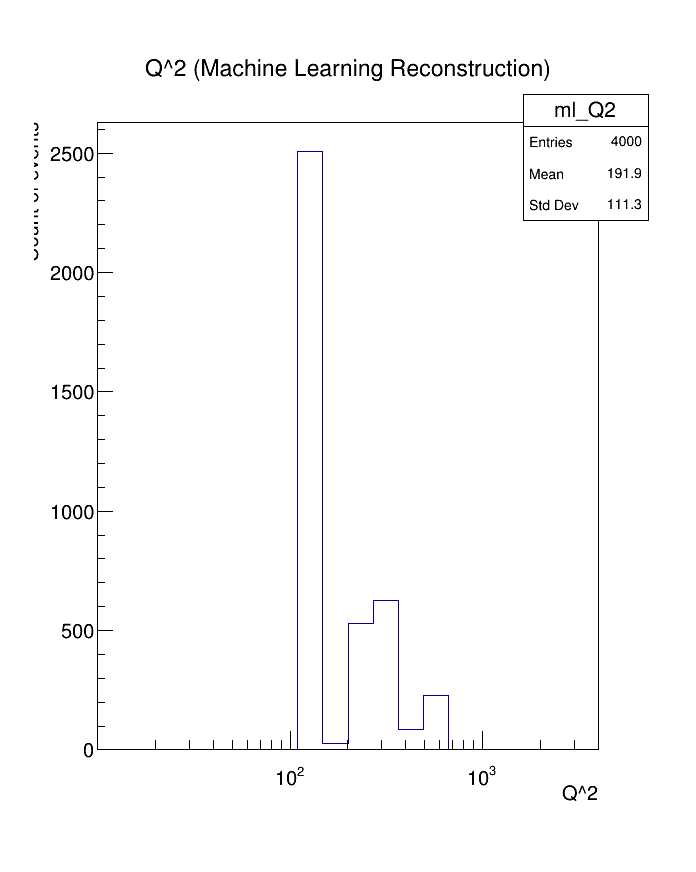

In [12]:
c_ml_Q2 = TCanvas('c_ml_Q2', 'The canvas with Q2 histogram', 200, 10, 700, 900)
pad_ml_Q2 = TPad('pad_ml_Q2', 'The pad with Q2 histogram', 0.05, 0.05, 0.95, 0.95)

pad_ml_Q2.Draw()
pad_ml_Q2.cd()
pad_ml_Q2.SetLogx()

ml_Q2_hist.GetXaxis().SetTitle('Q^2')
ml_Q2_hist.GetYaxis().SetTitle('Count of events')
ml_Q2_hist.Draw()

c_ml_Q2.Update()
c_ml_Q2.Draw()

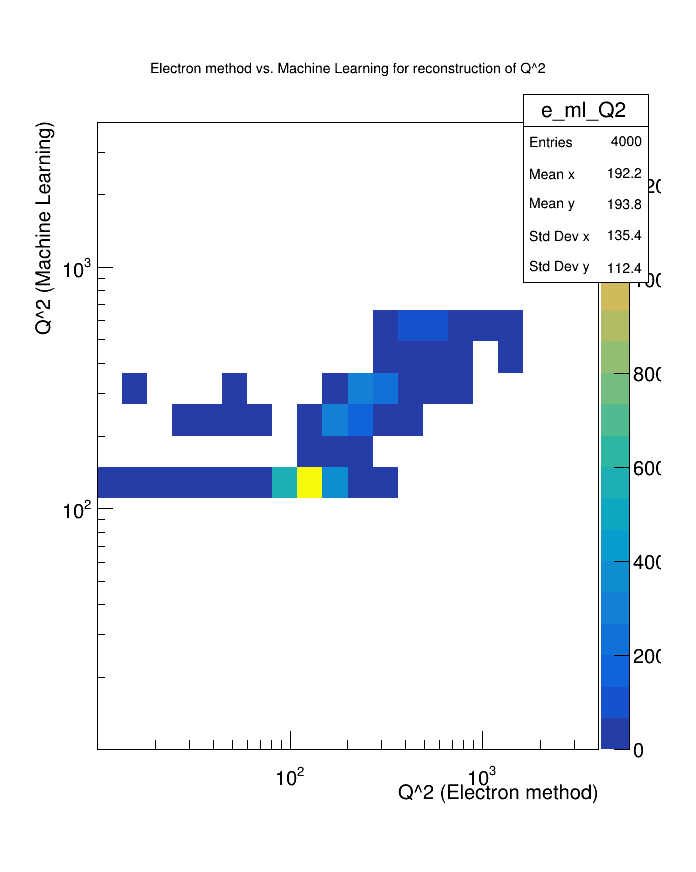

In [13]:
c_e_ml_Q2 = TCanvas('c_e_ml_Q2', 'The canvas with e vs. JB Q2', 200, 10, 700, 900)
pad_e_ml_Q2 = TPad('pad_e_ml_Q2', 'The pad with e vs. JB Q2', 0.05, 0.05, 0.95, 0.95)

pad_e_ml_Q2.Draw()
pad_e_ml_Q2.cd()
pad_e_ml_Q2.SetLogx()
pad_e_ml_Q2.SetLogy()

e_ml_Q2.GetXaxis().SetTitle('Q^2 (Electron method)')
e_ml_Q2.GetYaxis().SetTitle('Q^2 (Machine Learning)')
e_ml_Q2.Draw('colz')

c_e_ml_Q2.Update()
c_e_ml_Q2.Draw()

In [14]:
output_file.Close()